# Noise Models

From the Spitzer handbook, we get:
$$SNR=0.86\sqrt{T_{exp}F},$$
with the cyro off, where $F$ is in ${\mu}\text{Jy}$ and $T_{exp}$ is in seconds.

$$\sigma_{F_{L}}=\ln{10}F\sigma_{I}/2.5$$

#### Zhu et al. 2017 sample:

[![Vizier](https://custom-icon-badges.demolab.com/badge/Vizier-gray.svg?logo=vizier&logoColor=orange&logoWidth=20)](https://doi.org/10.26093/cds/vizier.51540210 "https://vizier.cds.unistra.fr/viz-bin/VizieR") [ADS link](https://ui.adsabs.harvard.edu/abs/2018yCat..51540210Z/abstract)

"This research has made use of the VizieR catalogue access tool, CDS,
 Strasbourg, France (DOI : 10.26093/cds/vizier). The original description 
 of the VizieR service was published in 2000, A&AS 143, 23"

In [1]:
# the catalogue name in VizieR
CATALOGUE = "J/AJ/154/210"

Oh screw those guys, it's just the tables from their paper, not a real catalog.

## OGLE

Let's just web scrape a bunch of OGLE events and figure out the noise model.

In [2]:
#@title Imports and Setup

# system tools
import os
import sys
from io import StringIO
import time
from typing import Tuple, Callable, Optional, List
import shutil

# data analysis tools
import numpy as np
import matplotlib.pyplot as plt
from IPython import get_ipython
from IPython.display import display
from scipy.optimize import minimize
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord

# web scrapping tools
import bs4 as bs
import urllib
import urllib.request
import pandas as pd

In [3]:
#@title Web scrapping functions

def get_data_url(event: str) -> str:
    '''Takes an event name and returns the URL for the data page.'''

    event = event.split('-') # split the event name into its components, seperated by '-'
    year = event[0]  # the first component is the year
    region = event[1].lower()  # the second component is region (e.g., blg or gd), which we need to make lower case.
    number = event[2]  #
    url = f'https://www.astrouw.edu.pl/ogle/ogle4/ews/{year}/{region}-{number}/phot.dat'

    return url

def fetch_event_data(url: str) -> pd.DataFrame:
    '''Takes a url and returns the data as a pandas dataframe.'''

    # Read the data from the URL
    response = urllib.request.urlopen(url)
    data = response.read().decode('utf-8')

    # Convert the data to a pandas DataFrame
    #df = pd.read_csv(StringIO(data), delim_whitespace=True, header=None, names=['HJD', 'I magnitude', 'magnitude error', 'seeing', 'sky level'])
    df = pd.read_csv(StringIO(data), sep=r'\s+', header=None, names=['HJD', 'I magnitude', 'magnitude error', 'seeing', 'sky level'])

    return df

# Test
event = '2017-BLG-0001'
event_data_url = get_data_url(event)
data = fetch_event_data(event_data_url)
print(data)

               HJD  I magnitude  magnitude error  seeing  sky level
0     2.457060e+06       17.644            0.034    7.59     1155.0
1     2.457061e+06       17.665            0.027    6.44      945.0
2     2.457061e+06       17.652            0.025    4.90     1305.0
3     2.457062e+06       17.682            0.024    5.85      934.0
4     2.457062e+06       17.702            0.023    5.10     1085.0
...            ...          ...              ...     ...        ...
2657  2.458047e+06       17.666            0.031    7.25      996.0
2658  2.458049e+06       17.661            0.018    4.33      703.0
2659  2.458049e+06       17.682            0.017    4.14      844.0
2660  2.458054e+06       17.672            0.035    6.18     1496.0
2661  2.458054e+06       17.686            0.041    7.01     1568.0

[2662 rows x 5 columns]


In [4]:
#@title More web scraping (this time for the EWS table)

def fetch_table_data(url):
    '''Takes a URL and returns the first table as a pandas DataFrame.'''
    source = urllib.request.urlopen(url).read()
    soup = bs.BeautifulSoup(source, 'html.parser')
    table = soup.find_all('table')
    df = pd.read_html(StringIO(str(table)))[0]

    return df

ews_url = "https://ogle.astrouw.edu.pl/ogle4/ews/ews.html"  # https://ogle.astrouw.edu.pl/ogle4/ews/2024/ews.html for last year
ews_df = fetch_table_data(ews_url)
print(ews_df)

# Adding a URL column to the data frame

# Add a new column to the EWS data frame ('ews_df'), using the column name 'event data url'.
ews_df['event data url'] = ews_df['Event'].apply(get_data_url)
print(ews_df)
print(min(ews_df['Tmax (HJD)']), max(ews_df['Tmax (HJD)']))
print(min(ews_df['Umin']), max(ews_df['Umin']))
print(min(ews_df['tau']), max(ews_df['tau']))

      Unnamed: 0          Event      Field  Star No   RA (J2000)  Dec (J2000)  \
0            NaN  2025-BLG-0001  BLG497.22    26223  17:19:44.68  -27:43:21.4   
1            NaN  2025-BLG-0002  BLG498.16    23293  17:17:24.61  -29:19:44.8   
2            NaN  2025-BLG-0003  BLG498.24   149001  17:18:03.34  -28:50:21.4   
3            NaN  2025-BLG-0004  BLG498.29     2940  17:20:03.15  -28:41:15.5   
4            NaN  2025-BLG-0005  BLG499.29    47835  17:19:54.58  -29:57:28.0   
...          ...            ...        ...      ...          ...          ...   
1364         NaN  2025-BLG-1338  BLG652.15    73712  17:38:55.50  -26:16:21.6   
1365         NaN  2025-BLG-1339  BLG652.15    74489  17:38:57.64  -26:17:16.1   
1366         NaN  2025-BLG-1340  BLG654.26    39817  17:37:38.89  -29:23:52.7   
1367         NaN  2025-BLG-1341  BLG661.20    58108  17:40:36.13  -33:20:52.6   
1368         NaN  2025-BLG-1342  BLG676.25    16729  17:38:17.56  -28:27:42.9   

       Tmax (HJD)      Tmax

In [5]:
N=50  # max N = len(ews_df)
OGLE_data = {}

for i in range(N):
    event = ews_df['Event'][i]
    print(event)
    print(ews_df.columns)
    url = ews_df['event data url'][i]
    data = fetch_event_data(url)
    OGLE_data[event] = data

2025-BLG-0001
Index(['Unnamed: 0', 'Event', 'Field', 'Star No', 'RA (J2000)', 'Dec (J2000)',
       'Tmax (HJD)', 'Tmax (UT)', 'tau', 'Umin', 'Amax', 'Dmag', 'fbl', 'Ibl',
       'I0', 'event data url'],
      dtype='object')
2025-BLG-0002
Index(['Unnamed: 0', 'Event', 'Field', 'Star No', 'RA (J2000)', 'Dec (J2000)',
       'Tmax (HJD)', 'Tmax (UT)', 'tau', 'Umin', 'Amax', 'Dmag', 'fbl', 'Ibl',
       'I0', 'event data url'],
      dtype='object')
2025-BLG-0002
Index(['Unnamed: 0', 'Event', 'Field', 'Star No', 'RA (J2000)', 'Dec (J2000)',
       'Tmax (HJD)', 'Tmax (UT)', 'tau', 'Umin', 'Amax', 'Dmag', 'fbl', 'Ibl',
       'I0', 'event data url'],
      dtype='object')
2025-BLG-0003
Index(['Unnamed: 0', 'Event', 'Field', 'Star No', 'RA (J2000)', 'Dec (J2000)',
       'Tmax (HJD)', 'Tmax (UT)', 'tau', 'Umin', 'Amax', 'Dmag', 'fbl', 'Ibl',
       'I0', 'event data url'],
      dtype='object')
2025-BLG-0003
Index(['Unnamed: 0', 'Event', 'Field', 'Star No', 'RA (J2000)', 'Dec (J2000)',
   

In [6]:
print(OGLE_data.keys())
print(OGLE_data['2025-BLG-0001'])

dict_keys(['2025-BLG-0001', '2025-BLG-0002', '2025-BLG-0003', '2025-BLG-0004', '2025-BLG-0005', '2025-BLG-0006', '2025-BLG-0007', '2025-BLG-0008', '2025-BLG-0009', '2025-BLG-0010', '2025-BLG-0011', '2025-BLG-0012', '2025-BLG-0013', '2025-BLG-0014', '2025-BLG-0015', '2025-BLG-0016', '2025-BLG-0017', '2025-BLG-0018', '2025-BLG-0019', '2025-BLG-0020', '2025-BLG-0021', '2025-BLG-0022', '2025-BLG-0023', '2025-BLG-0024', '2025-BLG-0025', '2025-BLG-0026', '2025-BLG-0027', '2025-BLG-0028', '2025-BLG-0029', '2025-BLG-0030', '2025-BLG-0031', '2025-BLG-0032', '2025-BLG-0033', '2025-BLG-0034', '2025-BLG-0035', '2025-BLG-0036', '2025-BLG-0037', '2025-BLG-0038', '2025-BLG-0039', '2025-BLG-0040', '2025-BLG-0041', '2025-BLG-0042', '2025-BLG-0043', '2025-BLG-0044', '2025-BLG-0045', '2025-BLG-0046', '2025-BLG-0047', '2025-BLG-0048', '2025-BLG-0049', '2025-BLG-0050'])
              HJD  I magnitude  magnitude error  seeing  sky level
0    2.457822e+06       20.079            0.223    4.66       83.0
1   

In [7]:
def mag_to_flux(mag, band="I", obs="OGLE", zp=None):
    """Convert magnitude to flux.
    
    Parameter
    ---------
    mag : float
        The magnitude to convert.
    band : str
        The photometric band (default is "I").
    obs : str
        The observatory name (default is "OGLE").
    zp : float
        The zero point for the conversion (optional, overrides preset).

    Returns
    -------
    float
        The flux corresponding to the input magnitude.

    Raises
    ------
    ValueError
        If the band/observatory combination is unknown.
    """
    zps = {"I_OGLE": 18.0, "L_Spitzer": 25.0}  # example zero points for I and L bands

    zp_ = zps.get(f"{band}_{obs}", None)
    if zp is not None:
        zp_ = zp

    if zp_ is not None:
        return 10.0 ** ((zp_ - mag) / 2.5)
    else:
        raise ValueError(f"Unknown band/observatory combination: {band}, {obs}")

/var/folders/yk/2lp5vmnd6s778_4bh__0mvyc0000gp/T/ipykernel_8703/4043494070.py:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


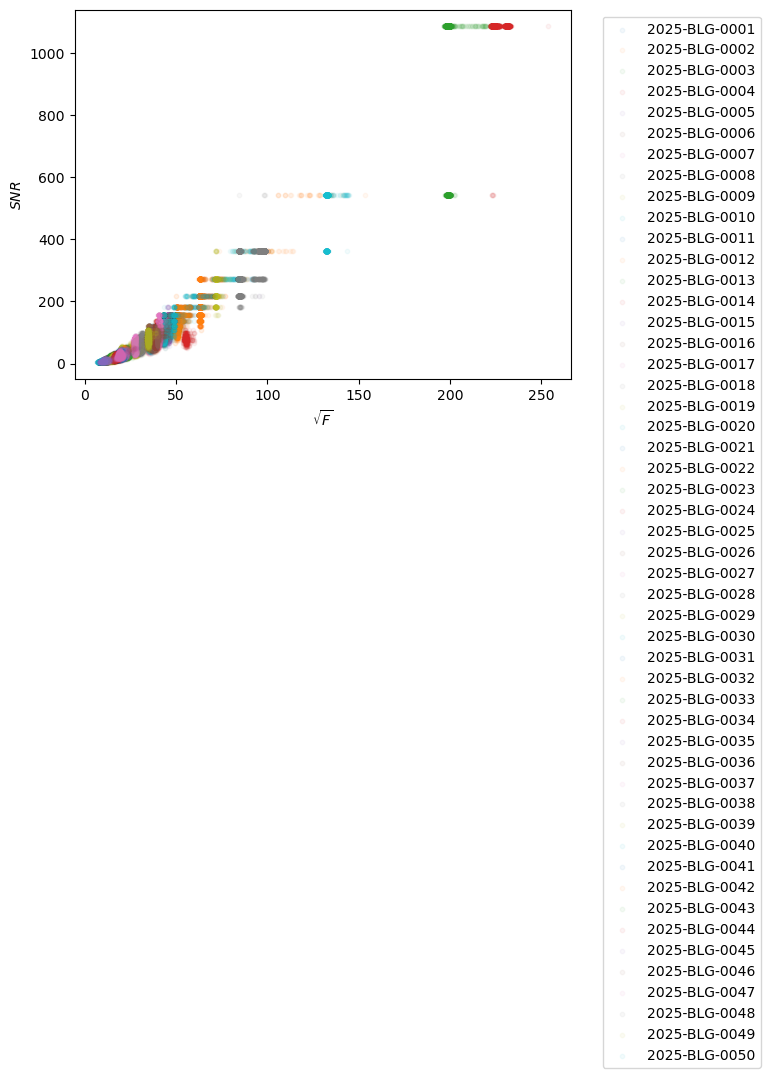

In [35]:
plt.figure()

X = []  # Use lists instead, much easier
Y = []

for event_id, data in OGLE_data.items():
    flux = mag_to_flux(data['I magnitude'].values, band="I", obs="OGLE", zp=25)  # .values converts pandas Series to numpy array
    flux_err = flux * data['magnitude error'].values * np.log(10) / 2.5  # Convert mag error to flux error

    y = flux/flux_err
    x = np.sqrt(flux)

    plt.scatter(x, y, label=event_id, alpha=0.05, s=10)
    
plt.ylabel(r"$SNR$")
#plt.xscale('log')
plt.xlabel(r"$\sqrt{F}$")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside plot
plt.tight_layout()
plt.show()

/var/folders/yk/2lp5vmnd6s778_4bh__0mvyc0000gp/T/ipykernel_8703/2972266914.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


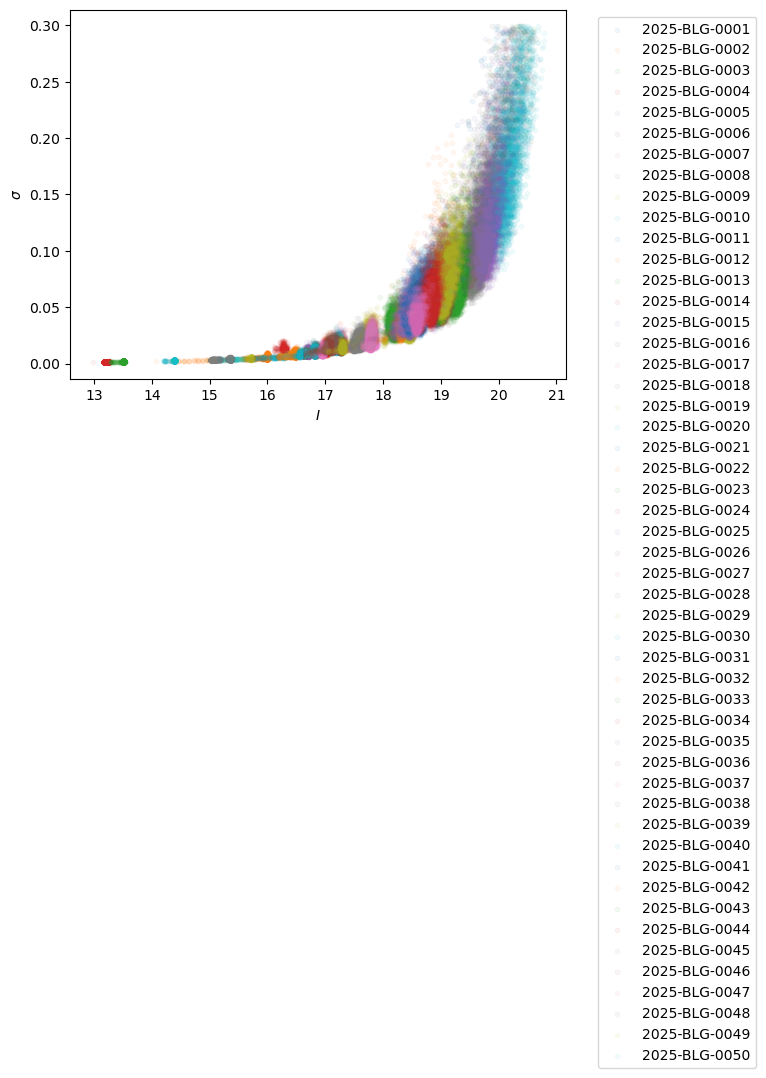

In [9]:
plt.figure()

X = []  # Use lists instead, much easier
Y = []

for event_id, data in OGLE_data.items():
    plt.scatter(data['I magnitude'], (data['magnitude error']), label=event_id, alpha=0.05, s=10)  # Added alpha and smaller size for better visualization

plt.ylabel(r"$\sigma$")
plt.xlabel(r"$I$")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside plot
plt.tight_layout()
plt.show()

In [10]:
# Effective SNR slope b_eff(F) from your fitted variance model
import numpy as np
import matplotlib.pyplot as plt

Fplot = np.logspace(np.log10(max(np.nanmin(F), 1e-3)), np.log10(np.nanmax(F)), 300)
den = (a*Fplot + b + c*Fplot**2)
num = (a*Fplot + 2*c*Fplot**2)
b_eff = 1.0 - 0.5 * (num / den)

plt.figure(figsize=(5.5, 4))
plt.semilogx(Fplot, b_eff, label='b_eff(F) = d ln SNR / d ln F')
plt.axhline(1.0, ls='--', c='k', lw=1)
plt.axhline(0.5, ls='--', c='k', lw=1)
plt.axhline(0.0, ls='--', c='k', lw=1)
plt.ylim(-0.05, 1.05)
plt.xlabel('F')
plt.ylabel('effective slope b_eff')
plt.title('Local power-law slope of SNR(F)')
plt.legend()
plt.show()

NameError: name 'F' is not defined

/var/folders/yk/2lp5vmnd6s778_4bh__0mvyc0000gp/T/ipykernel_8703/3554634942.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


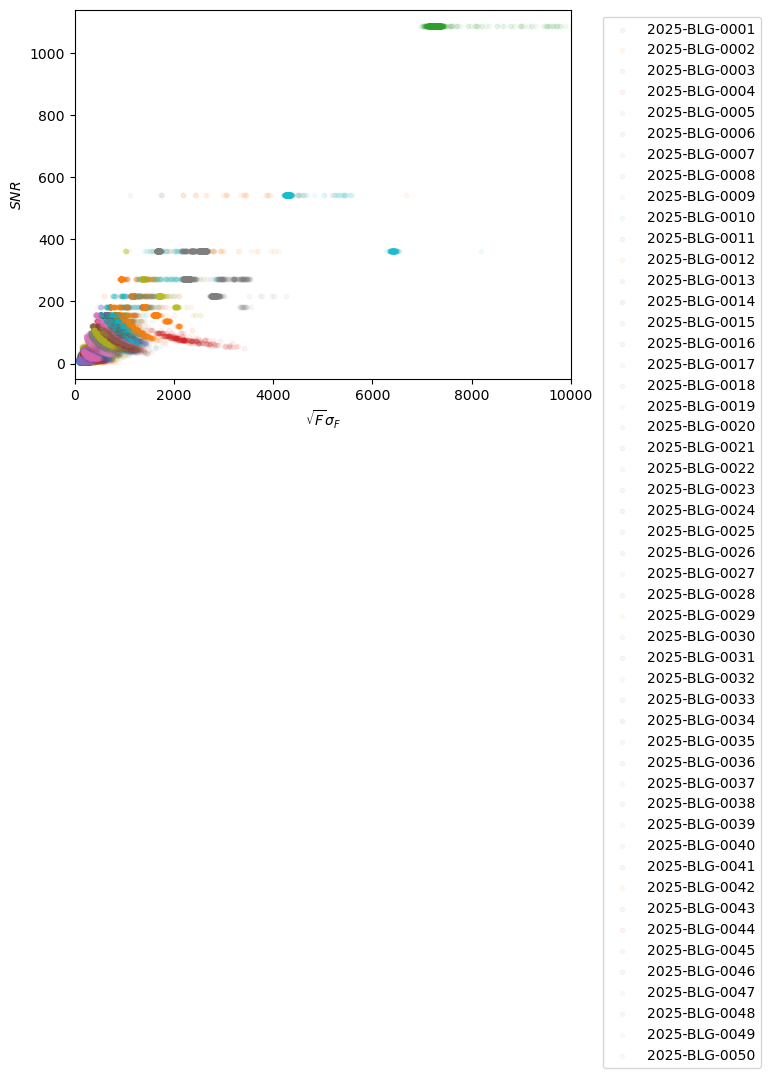

In [11]:
plt.figure()

X = []  # Use lists instead, much easier
Y = []

for event_id, data in OGLE_data.items():
    flux = mag_to_flux(data['I magnitude'].values, band="I", obs="OGLE", zp=25)  # .values converts pandas Series to numpy array
    flux_err = flux * data['magnitude error'].values * np.log(10) / 2.5  # Convert mag error to flux error
    snr= flux / flux_err # = F * 2.5 / (F * mag_err * ln(10)) = 2.5 / (mag_err * ln(10))
    #print(f"SNR ({event_id}): min={min(snr)}, max={max(snr)}, mean={np.mean(snr)}")

    #y = 2.5 /(np.log(10.0) * data['magnitude error'].values)  # .values converts to numpy array
    y = snr
    x = np.sqrt(flux)*flux_err

    plt.scatter(x, y, label=event_id, alpha=0.05, s=10)
    
plt.ylabel(r"$SNR$")
#plt.xscale('log')
plt.xlabel(r"$\sqrt{F}\sigma_{F}$")
plt.xlim(0,10000)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside plot
plt.tight_layout()
plt.show()

### OGLE I-band S/N model

ODR Fit Results:
Slope: 2028.551988 ± 2.401247
Intercept: 119.935004 ± 5.247288
Reduced Chi-squared: 0.561524


/var/folders/yk/2lp5vmnd6s778_4bh__0mvyc0000gp/T/ipykernel_8703/3001891790.py:104: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


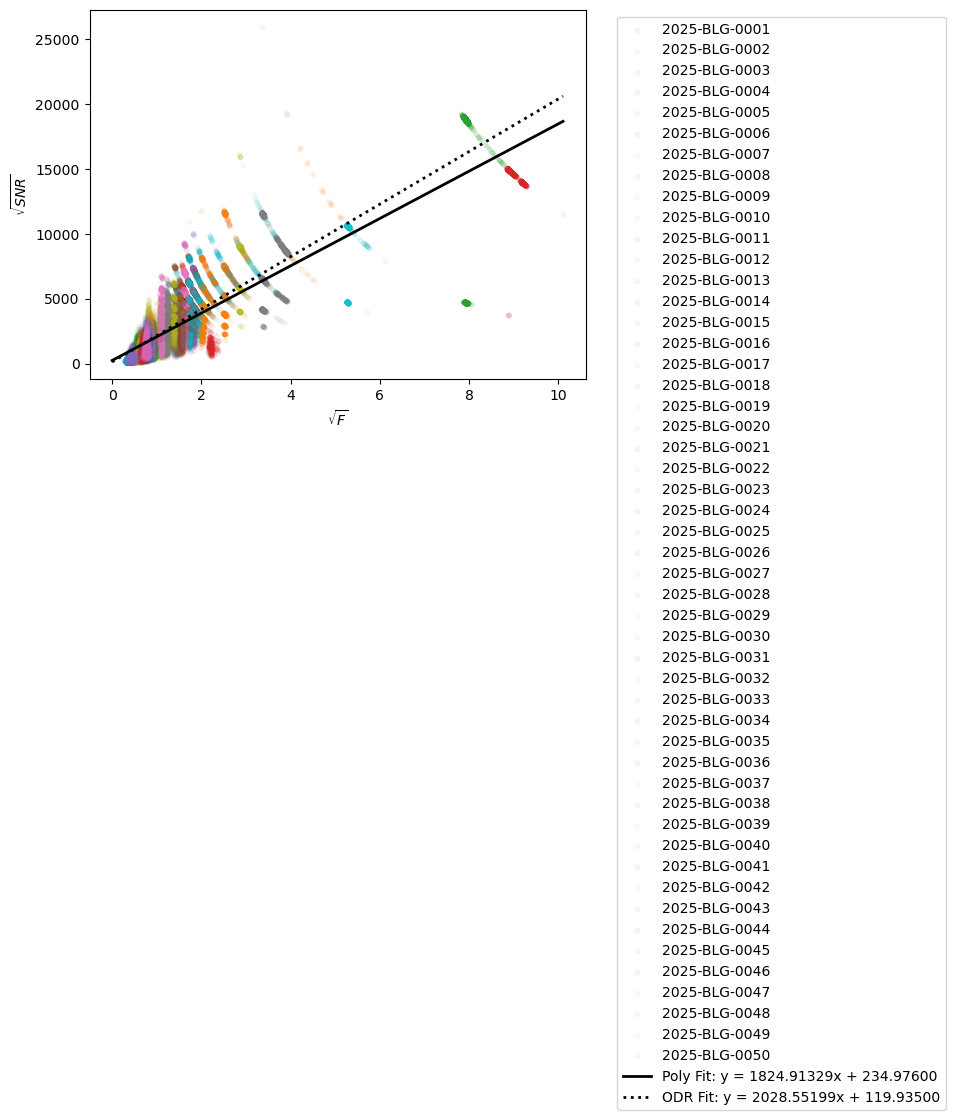

In [12]:
# plotting the SNR proxies

plt.figure()

X = []  # Use lists instead, much easier
Y = []

for event_id, data in OGLE_data.items():
    flux = mag_to_flux(data['I magnitude'].values, band="I", obs="OGLE")  # .values converts pandas Series to numpy array
    flux_err = flux * data['magnitude error'].values * np.log(10) / 2.5  # Convert mag error to flux error
    snr= flux / flux_err**2  # = F * 2.5 / (F * mag_err * ln(10)) = 2.5 / (mag_err * ln(10))
    #print(f"SNR ({event_id}): min={min(snr)}, max={max(snr)}, mean={np.mean(snr)}")

    #y = 2.5 /(np.log(10.0) * data['magnitude error'].values)  # .values converts to numpy array
    y = snr
    x = np.sqrt(flux)

    plt.scatter(x, y, label=event_id, alpha=0.05, s=10)  # Added alpha and smaller size for better visualization

    X.extend(x)  # Add all points to the list
    Y.extend(y)

# Convert lists to numpy arrays for fitting
X = np.array(X)
Y = np.array(Y)

# Fit a line to all the data
def line(x, m, c=0):
    y = m*x + c
    return y

def chi2(args, model, x, y):
    residuals = y - model(x, *args)
    return np.sum(residuals**2)/x**2

def lnprob(args, model, x, y):
    return -0.5 * chi2(args, model, x, y)

# emcee
# from emcee import EnsembleSampler
# ndim = 2
# nwalkers = 50
# nsteps = 1000
# nburn = 500
# p0 = [1800, 0.0]
# p0_state = p0 + 1e-4 * np.random.randn(nwalkers, ndim)  # initial guess for m and c

# sampler = EnsembleSampler(nwalkers, ndim, lnprob, args=(line, X, Y))
# sampler.run_mcmc(p0_state, nsteps)

xx = np.linspace(0, np.max(X), 100)
# yy = sampler.flatchain[nburn*nwalkers:, 0].mean() * xx + sampler.flatchain[nburn*nwalkers:, 1].mean()

# plt.plot(xx, yy, color='black', linestyle='--', linewidth=2, label=f'Fit: y = {sampler.flatchain[:, 0].mean():.5f}x + {sampler.flatchain[:, 1].mean():.5f}')   

# # plot the last 50 samples
# for i in range(50):
#     m = sampler.flatchain[-i, 0]
#     c = sampler.flatchain[-i, 1]
#     print(f"Sample {i}: m={m}, c={c}")
#     plt.plot(xx, line(xx, m, c), color='gray', alpha=0.3)

#fit a line using np.poly
coeffs = np.polyfit(X, Y, 1)
poly = np.poly1d(coeffs)
plt.plot(xx, poly(xx), color='black', linestyle='-', linewidth=2, label=f'Poly Fit: y = {coeffs[0]:.5f}x + {coeffs[1]:.5f}')

# orthogonal distance regression fit a linear line using the poly coeffs 
# for an initial guess using scipy ODR
from scipy import odr

# Define the linear function for ODR
def linear_func(p, x):
    """Linear function: y = p[0]*x + p[1]"""
    return p[0] * x + p[1]

# Create a Model
linear_model = odr.Model(linear_func)

# Create RealData object with weights (assuming equal weights for now)
# You could add error estimates here if you have them
data = odr.RealData(X, Y)

# Set up ODR with initial guess from polyfit
odr_obj = odr.ODR(data, linear_model, beta0=coeffs)

# Run the regression
output = odr_obj.run()

# Plot ODR fit
odr_coeffs = output.beta
plt.plot(xx, linear_func(odr_coeffs, xx), color='black', linestyle=':', linewidth=2, 
         label=f'ODR Fit: y = {odr_coeffs[0]:.5f}x + {odr_coeffs[1]:.5f}')

# Print fit results
print("ODR Fit Results:")
print(f"Slope: {odr_coeffs[0]:.6f} ± {output.sd_beta[0]:.6f}")
print(f"Intercept: {odr_coeffs[1]:.6f} ± {output.sd_beta[1]:.6f}")
print(f"Reduced Chi-squared: {output.res_var:.6f}")

plt.ylabel(r"$\sqrt{SNR}$")
plt.xlabel(r"$\sqrt{F}$")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside plot
plt.tight_layout()
plt.show()

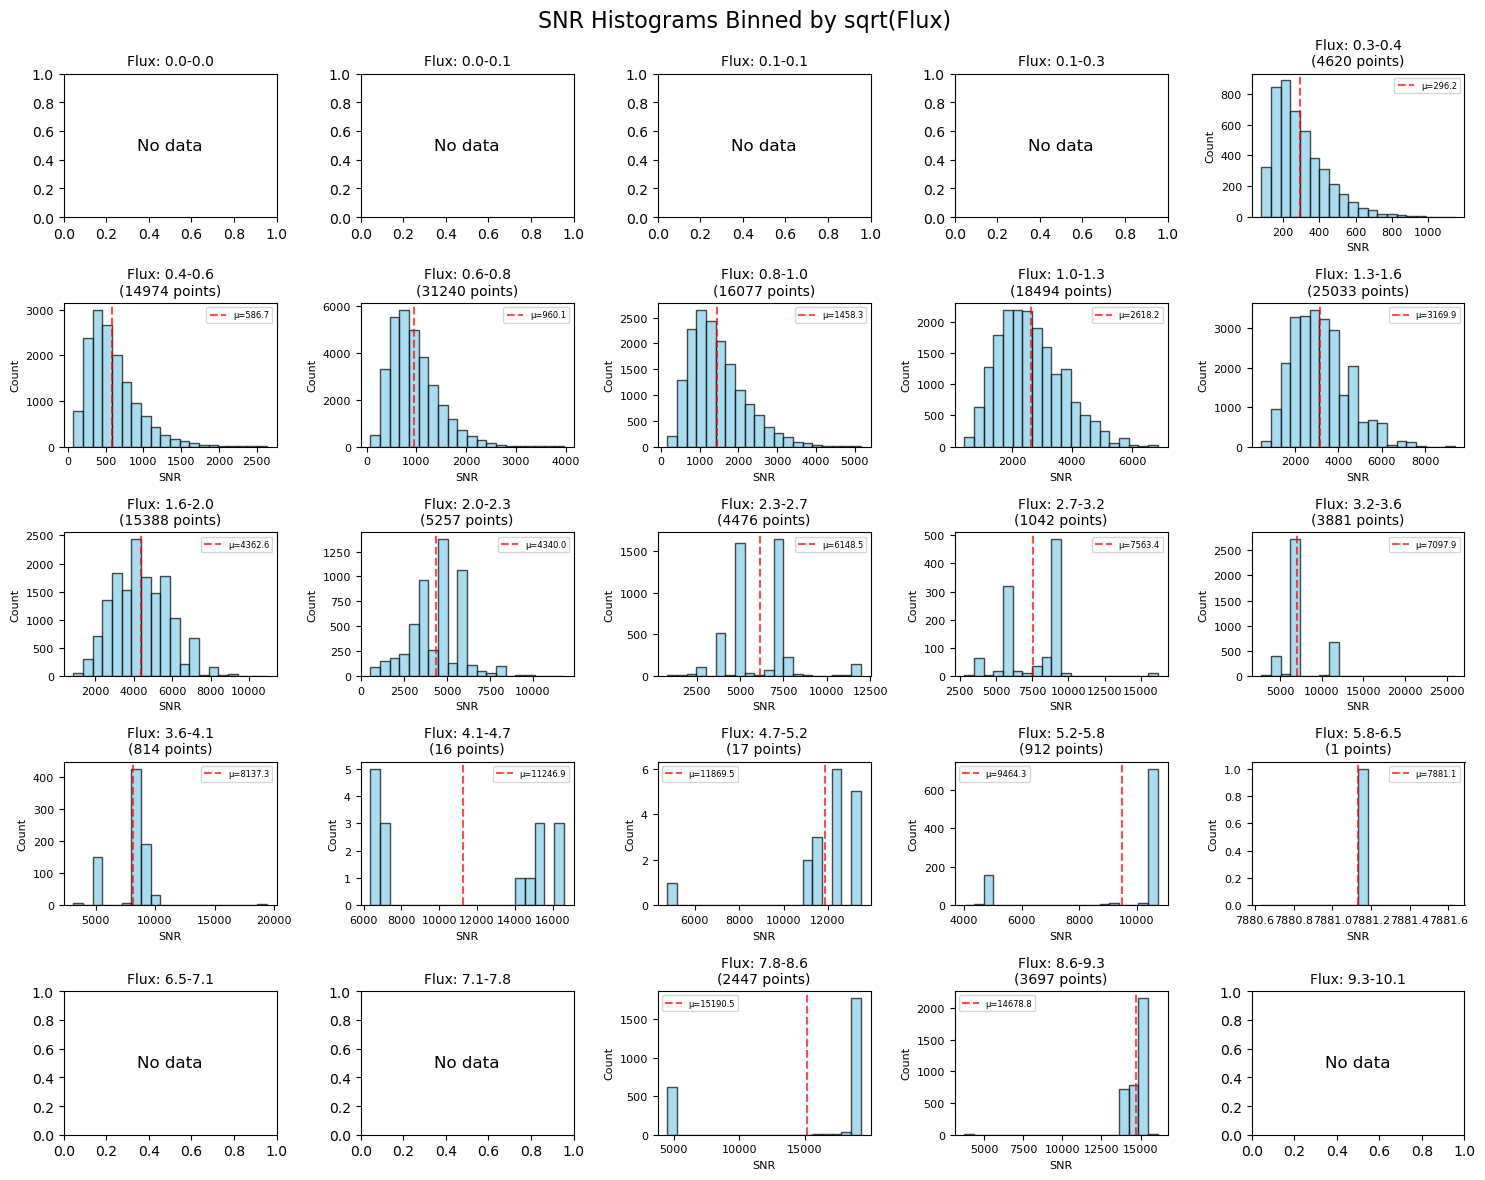

Summary of bins:
Bin  0: Flux    0.0-0.0, no data
Bin  1: Flux    0.0-0.1, no data
Bin  2: Flux    0.1-0.1, no data
Bin  3: Flux    0.1-0.3, no data
Bin  4: Flux    0.3-   0.4,  4620 points, SNR mean= 296.2, std= 147.4
Bin  5: Flux    0.4-   0.6, 14974 points, SNR mean= 586.7, std= 322.5
Bin  6: Flux    0.6-   0.8, 31240 points, SNR mean= 960.1, std= 475.5
Bin  7: Flux    0.8-   1.0, 16077 points, SNR mean=1458.3, std= 698.7
Bin  8: Flux    1.0-   1.3, 18494 points, SNR mean=2618.2, std=1063.0
Bin  9: Flux    1.3-   1.6, 25033 points, SNR mean=3169.9, std=1267.3
Bin 10: Flux    1.6-   2.0, 15388 points, SNR mean=4362.6, std=1413.9
Bin 11: Flux    2.0-   2.3,  5257 points, SNR mean=4340.0, std=1500.2
Bin 12: Flux    2.3-   2.7,  4476 points, SNR mean=6148.5, std=1785.8
Bin 13: Flux    2.7-   3.2,  1042 points, SNR mean=7563.4, std=1928.6
Bin 14: Flux    3.2-   3.6,  3881 points, SNR mean=7097.9, std=2198.9
Bin 15: Flux    3.6-   4.1,   814 points, SNR mean=8137.3, std=1662.6
Bin 16: Flu

In [13]:
# bin along the sqrt(F) x-axis - create 25 bins for 5x5 subplot grid
xx = np.linspace(0, np.sqrt(np.max(X)), 26)  # 26 edges for 25 bins
xx = xx**2  # convert back to flux space
binned_data = {}

# Create the 5x5 subplot figure
fig, axes = plt.subplots(5, 5, figsize=(15, 12))
fig.suptitle('SNR Histograms Binned by sqrt(Flux)', fontsize=16)

# Process each bin
for i in range(25):  # 25 bins for 5x5 grid
    mask = (X >= xx[i]) & (X < xx[i+1])
    
    # Calculate subplot position (row, col)
    row = i // 5  # Integer division gives row (0-4)
    col = i % 5   # Modulo gives column (0-4)
    
    ax = axes[row, col]
    
    if np.any(mask):
        # Get the SNR values for this flux bin
        snr_values = Y[mask]
        binned_data[f'bin_{i}'] = snr_values
        
        # Create histogram
        ax.hist(snr_values, bins=20, alpha=0.7, edgecolor='black', color='skyblue')
        ax.set_title(f'Flux: {xx[i]:.1f}-{xx[i+1]:.1f}\n({len(snr_values)} points)', fontsize=10)
        ax.set_ylabel('Count', fontsize=8)
        ax.set_xlabel('SNR', fontsize=8)
        ax.tick_params(labelsize=8)
        
        # Add some statistics
        mean_snr = np.mean(snr_values)
        std_snr = np.std(snr_values)
        ax.axvline(mean_snr, color='red', linestyle='--', alpha=0.7, label=f'μ={mean_snr:.1f}')
        ax.legend(fontsize=6)
    else:
        # No data in this bin
        ax.text(0.5, 0.5, 'No data', transform=ax.transAxes, 
                ha='center', va='center', fontsize=12)
        ax.set_title(f'Flux: {xx[i]:.1f}-{xx[i+1]:.1f}', fontsize=10)

plt.tight_layout()
plt.show()

# Print summary statistics
mu, std = [], []
print("Summary of bins:")
for i in range(25):
    if f'bin_{i}' in binned_data:
        data = binned_data[f'bin_{i}']
        mu.append(np.mean(data))
        std.append(np.std(data))
        print(f"Bin {i:2d}: Flux {xx[i]:6.1f}-{xx[i+1]:6.1f}, "
              f"{len(data):5d} points, "
              f"SNR mean={np.mean(data):6.1f}, std={np.std(data):6.1f}")
    else:
        mu.append(np.nan)
        std.append(np.nan)
        print(f"Bin {i:2d}: Flux {xx[i]:6.1f}-{xx[i+1]:.1f}, no data")

Number of valid data points for fitting: 16
X_mu range: 0.33 to 8.19
Y_mu range: 296.18 to 15190.54
Fit parameters: slope=2272.16617, intercept=-464.71412


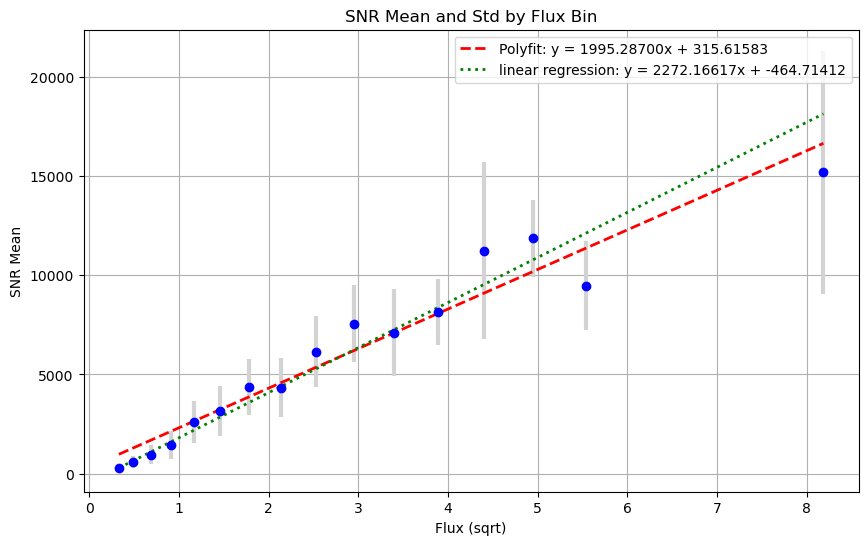

In [14]:
# plot sqrtF vs mu and std
import scipy.optimize as op

# Convert lists to numpy arrays for proper indexing
# remove the 19 value
mu = np.array(mu)
std = np.array(std)
# remove the 19 value
mu[19] = np.nan
std[19] = np.nan
mu[23] = np.nan
std[23] = np.nan

plt.figure(figsize=(10, 6))
# x is the midpoint of each bin in sqrt(Flux) space
x_mu = 0.5 * (xx[:-1] + xx[1:])
#plt.plot(x_mu[23], mu[23], "yo", zorder=5)  # using to locate specific points
plt.errorbar(x_mu, mu, yerr=std, fmt='o', color='blue', ecolor='lightgray', elinewidth=3, capsize=0)

# fit a line to the data using std weighted linear regression
def chi2(p, x_mu, mu, std):
    return np.sum((linear_func(p, x_mu) - mu) ** 2 / std ** 2)

nan_mask = ~np.isnan(mu) & ~np.isnan(std) & (std > 0)  # mask to ignore NaNs and std<=0
X_mu = x_mu[nan_mask]
Y_mu = mu[nan_mask]
Y_std = std[nan_mask]

print(f"Number of valid data points for fitting: {len(X_mu)}")
print(f"X_mu range: {X_mu.min():.2f} to {X_mu.max():.2f}")
print(f"Y_mu range: {Y_mu.min():.2f} to {Y_mu.max():.2f}")

poly_coeffs = np.polyfit(X_mu, Y_mu, 1)
x_fit = np.linspace(np.min(x_mu[nan_mask]), np.max(x_mu[nan_mask]), 100)
plt.plot(x_fit, np.polyval(poly_coeffs, x_fit), color='red', linestyle='--', linewidth=2,
            label=f'Polyfit: y = {poly_coeffs[0]:.5f}x + {poly_coeffs[1]:.5f}')

# fit with Nelder-mead
p0 = [poly_coeffs[0], poly_coeffs[1]]  # initial guess from polyfit
result = op.minimize(chi2, p0, args=(X_mu, Y_mu, Y_std), method='Nelder-Mead')
popt = result.x
print(f"Fit parameters: slope={popt[0]:.5f}, intercept={popt[1]:.5f}")

# Calculate x range for plotting fit line
x_fit = np.linspace(np.min(x_mu[nan_mask]), np.max(x_mu[nan_mask]), 100)
plt.plot(x_fit, linear_func(popt, x_fit), color='green', linestyle=':', linewidth=2, 
            label=f'linear regression: y = {popt[0]:.5f}x + {popt[1]:.5f}')

plt.ylabel('SNR Mean')
plt.xlabel('Flux (sqrt)')
plt.title('SNR Mean and Std by Flux Bin')
plt.legend()
plt.grid()
plt.show()

MLE: [2273.02070285 -462.41720777], 16th percentile: [2060.2604588  -628.69092743], 84th percentile: [2481.85879419 -295.02957115]
uncertainties: +([208.83809134 167.38763662]), -([212.76024405 166.27371966])


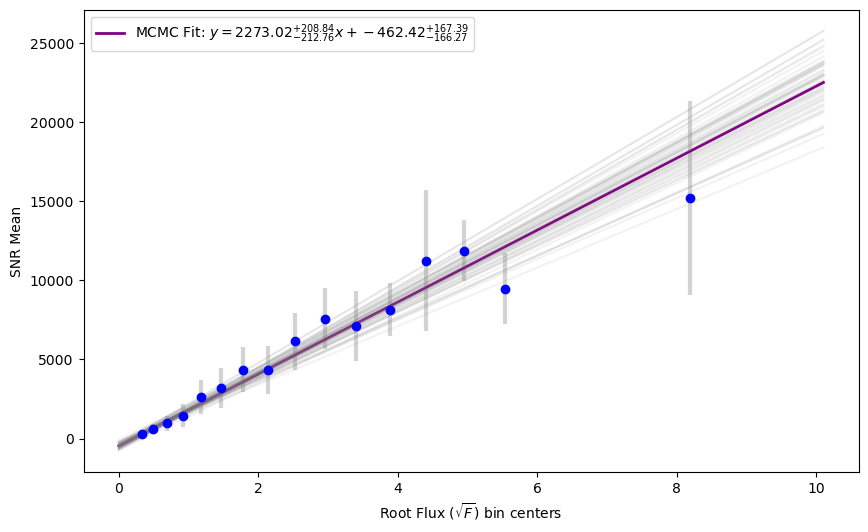

In [15]:
# use emcee to fit a posterior distribution
import emcee

def lnprob(theta, x, y, yerr):
    """Log-probability function for emcee."""
    # Unpack parameters
    m, b = theta
    # Compute the log-probability
    chi2_val = np.nansum(((y - (m * x + b)) / yerr) ** 2)
    if np.isnan(chi2_val):
        return -np.inf
    return -0.5 * chi2_val

p0 = popt
ndim = len(p0)
nwalkers = 50
pos = [p0 + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x_mu, mu, std))

plt.figure(figsize=(10, 6))
# x is the midpoint of each bin in sqrt(Flux) space
plt.errorbar(x_mu, mu, yerr=std, fmt='o', color='blue', ecolor='lightgray', elinewidth=3, capsize=0)

sampler.run_mcmc(pos, 1000)
pos = sampler.get_chain()[-100:, :, :]
pos = pos.reshape((-1, ndim))
mle = np.percentile(pos, 50, axis=0)
p16 = np.percentile(pos, 16, axis=0)
p84 = np.percentile(pos, 84, axis=0)
print(f'MLE: {mle}, 16th percentile: {p16}, 84th percentile: {p84}')
lower = mle - p16
upper = p84 - mle
print(f'uncertainties: +({upper}), -({lower})')

plt.plot(xx, linear_func(mle, xx), color='purple', linestyle='-', linewidth=2, 
            label=f'MCMC Fit: $y = {mle[0]:.2f}^{{+{upper[0]:.2f}}}_{{-{lower[0]:.2f}}}x + {mle[1]:.2f}^{{+{upper[1]:.2f}}}_{{-{lower[1]:.2f}}}$')

# plot the walkers in the last state
for i in range(nwalkers):
    n = np.random.randint(0, 100)
    nw = np.random.randint(0, nwalkers)
    plt.plot(xx, pos[n*nwalkers+nw, 0] * xx + pos[n*nwalkers+nw, 1], color='gray', alpha=0.1)

plt.ylabel('SNR Mean')
plt.xlabel(f'Root Flux ($\sqrt{{F}}$) bin centers')
plt.legend()
plt.savefig('mcmc_fit_OGLE_SN_model.png')

ODR Fit Results:
Slope: 559.374250 ± 25.782801
Intercept: 230.159888 ± 76.645131
Reduced Chi-squared: 0.098713


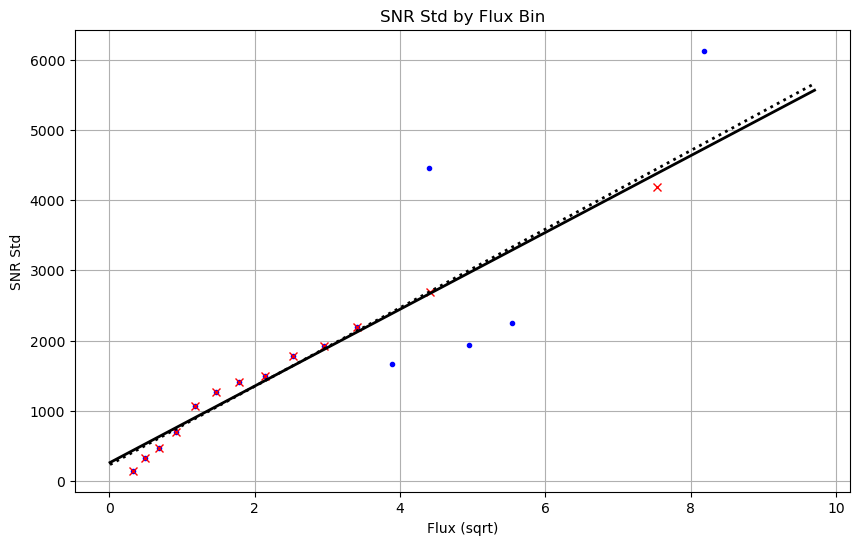

In [16]:
# plot x vs std
plt.figure(figsize=(10, 6))
plt.plot(x_mu, std, 'b.')
# bin 15 - 17
std_binned = np.zeros(13)
x_binned = np.zeros(13)
std_binned[0:11] = std[4:15]
std_binned[-2] = np.sum(std[15:18])/3.0
last_points = std[18:]
last_points = last_points[~np.isnan(last_points)]
last_points = last_points[last_points>100]
std_binned[-1] = np.nansum(last_points)/len(last_points)
x_binned[0:11] = x_mu[4:15]
x_binned[-2] = np.mean(x_mu[15:18])
x_binned[-1] = np.mean(x_mu[18:])

plt.plot(x_binned, std_binned, 'rx')
# find liner trend using odr
#fit a line using np.poly
coeffs = np.polyfit(x_binned, std_binned, 1)
poly = np.poly1d(coeffs)
plt.plot(x_mu, poly(x_mu), color='black', linestyle='-', linewidth=2, label=f'Poly Fit: y = {coeffs[0]:.5f}x + {coeffs[1]:.5f}')

# orthogonal distance regression fit a linear line using the poly coeffs 
# for an initial guess using scipy ODR
from scipy import odr

# Define the linear function for ODR
def linear_func(p, x):
    """Linear function: y = p[0]*x + p[1]"""
    return p[0] * x + p[1]

# Create a Model
linear_model = odr.Model(linear_func)

# Create RealData object with weights (assuming equal weights for now)
# You could add error estimates here if you have them
data = odr.RealData(x_binned, std_binned)

# Set up ODR with initial guess from polyfit
odr_obj = odr.ODR(data, linear_model, beta0=coeffs)

# Run the regression
output = odr_obj.run()

# Plot ODR fit
odr_coeffs = output.beta
plt.plot(x_mu, linear_func(odr_coeffs, x_mu), color='black', linestyle=':', linewidth=2, 
         label=f'ODR Fit: y = {odr_coeffs[0]:.5f}x + {odr_coeffs[1]:.5f}')

# Print fit results
print("ODR Fit Results:")
print(f"Slope: {odr_coeffs[0]:.6f} ± {output.sd_beta[0]:.6f}")
print(f"Intercept: {odr_coeffs[1]:.6f} ± {output.sd_beta[1]:.6f}")
print(f"Reduced Chi-squared: {output.res_var:.6f}")


plt.ylabel('SNR Std')
plt.xlabel('Flux (sqrt)')
plt.title('SNR Std by Flux Bin')
plt.grid()
plt.show()

## Spitzer

In [17]:
data_dir = "data/Spitzer/"

Spitzer_data = {}
for f in os.listdir(data_dir):
    if f.endswith(".dat") or f.endswith(".out"):
        event_id = f.split('.')[0]
        data = pd.read_csv(os.path.join(data_dir, f), header=None, sep=' ')
        
        if f.endswith(".out"):
            data = data.rename(columns={4: 'HJD_', 5: 'L flux', 6: 'flux error', 0: 'other1', 1: 'other2', 2: 'other3', 3: 'other4'})
            data = data[['HJD_', 'L flux', 'flux error']]
        else:
            # drop columns with NaN values
            data = data.dropna(axis=1)
            # get remaining column indexes
            remaining_cols = data.columns
            data = data.rename(columns={remaining_cols[0]: 'HJD_', remaining_cols[1]: 'L magnitude', remaining_cols[2]: 'magnitude error'})

            if event_id == "OB161195":
                zp = 18
            elif event_id == "OB161093":
                zp = 18.8
                
            data["L flux"] = mag_to_flux(data['L magnitude'].values, band="L", obs="Spitzer", zp=zp)
            data["flux error"] = data["L flux"] * data['magnitude error'].values * np.log(10) / 2.5

        # Process the data as needed
        Spitzer_data[event_id] = data

In [18]:
print(Spitzer_data.keys())
Spitzer_data['OB161195'].head()
S = {
    'OB161195': 1.0,  # 0.65, 1.77
    'OB161093': 1.0,  # 0.9, 0.4
    'OB171038': 1.0
}

for event_id, data in Spitzer_data.items():
    err_rescaling = S.get(event_id, 1.0)
    data['flux error rescaled'] = data['flux error'] * err_rescaling


dict_keys(['OB171038', 'OB161195', 'OB161093'])


SNR (OB171038): min=275.08857494403844, max=472.5308110308972, mean=nan
SNR (OB161195): min=11.599745777330442, max=35.832878044822756, mean=19.58815839293461
SNR (OB161093): min=53.85596253760563, max=111.47188960555742, mean=75.68895753527079


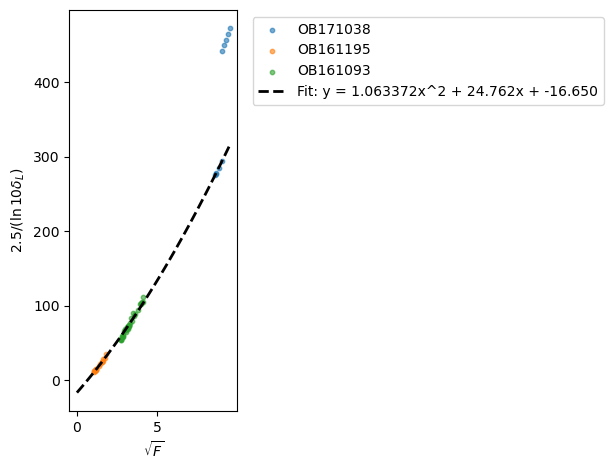

In [28]:
# plotting the SNR proxies

plt.figure()

X = []  # Use lists instead, much easier
Y = []

for event_id, data in Spitzer_data.items():
    flux = data['L flux'].values  # .values converts pandas Series to numpy array
    flux_err =data['flux error rescaled'].values
    snr= flux / flux_err  # = F * 2.5 / (F * mag_err * ln(10)) = 2.5 / (mag_err * ln(10))
    print(f"SNR ({event_id}): min={min(snr)}, max={max(snr)}, mean={np.mean(snr)}")

    y = snr.copy()  # .values converts to numpy array
    x = np.sqrt(flux)

    plt.scatter(x, y, label=event_id, alpha=0.6, s=10)  # Added alpha and smaller size for better visualization

    X.extend(x)  # Add all points to the list
    Y.extend(y)

# Convert lists to numpy arrays for fitting
X = np.array(X)
Y = np.array(Y)

# Fit a line to all the data

m = np.polyfit(X[(Y<400)], Y[(Y<400)], 2)

xx = np.linspace(0, np.max(X), 100)
yy = m[0] * xx**2 + m[1] * xx + m[2]

#plt.plot(X[~((Y<400)*(X>5))], Y[~((Y<400)*(X>5))], 'kx')

plt.plot(xx, yy, color='black', linestyle='--', linewidth=2, label=f'Fit: y = {m[0]:.6f}x^2 + {m[1]:.3f}x + {m[2]:.3f}')

plt.ylabel(r"$2.5 /(\ln{10}\delta_{L})$")
plt.xlabel(r"$\sqrt{F}$")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside plot
plt.tight_layout()
#plt.xlim(8, 10)
plt.show()

### Physically motivated noise fits

To sanity-check the metric you're plotting, it's better to fit the noise in flux units directly and then map to magnitude:

- In counts/flux space, a standard model is: $\sigma_F^2 = a\,F + b + c\,F^2$ where
  - $a\,F$ = Poisson/shot noise term
  - $b$ = background/read/readout constant term
  - $c\,F^2$ = multiplicative systematics (e.g., flat-fielding, calibration, PSF errors)
- Propagating to magnitudes: $\sigma_m^2 = \big(\tfrac{2.5}{\ln 10}\big)^2\,\frac{\sigma_F^2}{F^2} = A\,\frac{1}{F} + B\,\frac{1}{F^2} + C$ with
  - $A = k^2 a$, $B = k^2 b$, $C = k^2 c$ and $k = 2.5/\ln 10$.

Below we fit both forms on all OGLE points and plot the results. This lets you read off the magnitude error floor ($\sqrt{C}$) and see if a linear ($aF+b$) or quadratic ($aF+b+cF^2$) flux-variance model is needed.

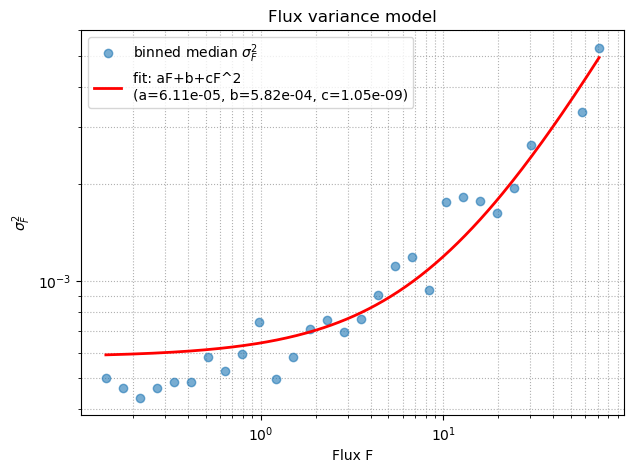

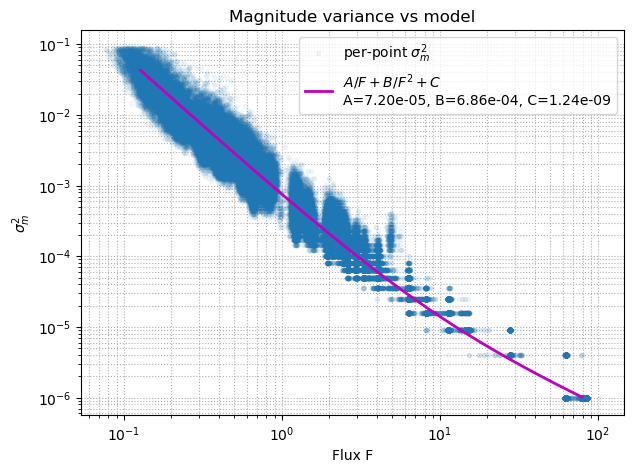

Noise params (flux space): a=6.105e-05 (shot), b=5.822e-04 (bg/read), c=1.048e-09 (systematic)
Noise params (mag space):  A=7.197e-05, B=6.863e-04, C=1.235e-09  -> mag floor ~ 0.0000 mag


In [29]:
# Aggregate OGLE flux and errors across all events
all_flux = []
all_flux_err = []
all_mag = []
all_mag_err = []

for event_id, df in OGLE_data.items():
    F = mag_to_flux(df['I magnitude'].values, band="I", obs="OGLE", zp=18.0)
    dF = F * df['magnitude error'].values * np.log(10.0) / 2.5
    all_flux.append(F)
    all_flux_err.append(dF)
    all_mag.append(df['I magnitude'].values)
    all_mag_err.append(df['magnitude error'].values)

F = np.concatenate(all_flux)
dF = np.concatenate(all_flux_err)
I = np.concatenate(all_mag)
dI = np.concatenate(all_mag_err)

# Clean obvious non-finite / pathological values
m = np.isfinite(F) & np.isfinite(dF) & (F > 0) & (dF >= 0)
F = F[m]
dF = dF[m]
I = I[m]
dI = dI[m]

# Bin in F to estimate variance robustly
nbins = 30
edges = np.geomspace(np.percentile(F, 1), np.percentile(F, 99), nbins+1)
centers = np.sqrt(edges[:-1]*edges[1:])
varF = np.full(nbins, np.nan)
count = np.zeros(nbins, dtype=int)

for i in range(nbins):
    sel = (F >= edges[i]) & (F < edges[i+1])
    if np.any(sel):
        # robust variance estimate of flux errors per bin
        varF[i] = np.nanmedian(dF[sel]**2)
        count[i] = np.sum(sel)

good = np.isfinite(varF) & (count >= 10)
Fc = centers[good]
varF_c = varF[good]

# Define models
# sigma_F^2 = a F + b + c F^2
def varF_model(F, a, b, c):
    return a*F + b + c*F**2

# Fit in log-space weights suppressed; do direct curve_fit with positive constraint via bounds
from scipy.optimize import curve_fit

p0 = [1.0, np.median(varF_c), 0.0]
bounds = ([-np.inf, 0.0, 0.0], [np.inf, np.inf, np.inf])  # allow a to be any sign; b,c >=0
pars, cov = curve_fit(varF_model, Fc, varF_c, p0=p0, bounds=bounds, maxfev=10000)
a,b,c = pars

# Plot sigma_F^2 vs F and fit
plt.figure(figsize=(7,5))
plt.loglog(Fc, varF_c, 'o', alpha=0.6, label='binned median $\sigma_F^2$')
Fplot = np.geomspace(Fc.min(), Fc.max(), 200)
plt.loglog(Fplot, varF_model(Fplot, *pars), 'r-', lw=2, label=f'fit: aF+b+cF^2\n(a={a:.2e}, b={b:.2e}, c={c:.2e})')
plt.xlabel('Flux F')
plt.ylabel('$\sigma_F^2$')
plt.title('Flux variance model')
plt.legend()
plt.grid(True, which='both', ls=':')
plt.show()

# Map to magnitude: sigma_m^2 = k^2 * sigma_F^2 / F^2
k = 2.5/np.log(10.0)
A = k**2 * a
B = k**2 * b
C = k**2 * c

# Compare to observed mag errors
plt.figure(figsize=(7,5))
plt.loglog(F, dI**2, '.', alpha=0.05, label='per-point $\sigma_m^2$')
Fplot = np.geomspace(np.percentile(F,1), np.percentile(F,99), 300)
model_mag_var = (A/Fplot) + (B/Fplot**2) + C
plt.loglog(Fplot, model_mag_var, 'm-', lw=2, label=f'$A/F + B/F^2 + C$\nA={A:.2e}, B={B:.2e}, C={C:.2e}')
plt.xlabel('Flux F')
plt.ylabel('$\sigma_m^2$')
plt.title('Magnitude variance vs model')
plt.legend()
plt.grid(True, which='both', ls=':')
plt.show()

print(f"Noise params (flux space): a={a:.3e} (shot), b={b:.3e} (bg/read), c={c:.3e} (systematic)")
print(f"Noise params (mag space):  A={A:.3e}, B={B:.3e}, C={C:.3e}  -> mag floor ~ {np.sqrt(C):.4f} mag")

### What is a per-epoch "flux error" and why 1.4826?

. In DIA/PSF photometry pipelines (e.g., OGLE), the per-epoch uncertainty is intended to be a 1σ standard deviation of the flux estimate, derived by propagating pixel-level noise (source Poisson, sky/background variance, read noise) through the PSF-weighted measurement and any difference-imaging model. In magnitude units, the pipeline reports an equivalent 1σ uncertainty `m_err`. It is not a variance; it’s a standard deviation (σ).
- In practice, pipelines often add components like: shot noise ∝ F, a background/read term (constant in counts), and sometimes multiplicative systematics (∝ F²). This is why fitting in flux variance space with σ_F² = aF + b + cF² is physically useful.
- Many surveys empirically rescale the quoted errors so that normalized residuals have unit scatter or χ²/dof ≈ 1. If your normalized residuals’ scatter is s ≠ 1, multiply the reported σ by s to bring it to ≈ 1.

About the "1.4826" (≈ 1.483) factor:
- The median absolute deviation (MAD) is MAD = median(|x − median(x)|). For a Gaussian, MAD × 1.4826 is an unbiased estimator of σ.
- We use this to be robust to outliers when measuring a distribution’s width: σ_robust ≈ 1.4826 × MAD.

Sanity check we use below:
- Define baseline (unmagnified) epochs per event via a MAD clip around the median magnitude.
- Compute normalized residuals z = (m − median)/σ_m on those baseline epochs.
- If the reported per-epoch errors are well calibrated, the robust std of z should be ≈ 1 across events; if it’s > 1, errors are underestimated; if < 1, errors are overestimated.

Reminder: SNR uses σ, not σ²
- In flux units, SNR = F/σ_F (not F/σ_F²).
- Using magnitude errors, SNR ≈ (2.5/ln 10)/σ_m under small-error linearization.

### Axes choice vs. model: what to justify
- Goal: a predictive noise model relating flux F to its uncertainty σ_F (or σ_F²). The physically interpretable space is variance vs flux:
  - Fit σ_F² = aF + b + cF² in flux units; map to magnitudes if needed.
- Use SNR vs √F only as a visualization:
  - SNR = F/σ_F; under pure Poisson noise, SNR ∝ √F (through origin).
  - Background (b) and multiplicative (c) terms bend this relation; linear-looking segments can be regime-dependent, so don’t fit polynomials there to infer noise physics.
- Recommendation you can state:
  1) Fit σ_F²(F) directly to get a,b,c; 2) derive SNR(F) = F/sqrt(aF + b + cF²); 3) optionally show SNR vs √F with the model curve overlaid to demonstrate consistency.

In [30]:
# Build normalized residuals on baseline and check scatter ~ 1
all_z = []
per_event_scale = {}

for event_id, df in OGLE_data.items():
    m = df['I magnitude'].values
    dm = df['magnitude error'].values
    # robust baseline: clip large excursions around median
    med = np.nanmedian(m)
    resid = m - med
    # MAD-based clip (keeps baseline, drops magnified epochs)
    mad = 1.4826 * np.nanmedian(np.abs(resid - np.nanmedian(resid)))
    keep = np.isfinite(m) & np.isfinite(dm) & (dm > 0)
    if mad > 0:
        keep &= (np.abs(resid) < 3*mad)
    z = (m[keep] - np.nanmedian(m[keep])) / dm[keep]
    if z.size >= 20:
        all_z.append(z)
        # robust std of z; should be ~1 if errors are 1σ
        robust_std = 1.4826*np.nanmedian(np.abs(z - np.nanmedian(z)))
        per_event_scale[event_id] = robust_std

# Stack and summarize
if all_z:
    zstack = np.concatenate(all_z)
    robust_std_all = 1.4826*np.nanmedian(np.abs(zstack - np.nanmedian(zstack, keepdims=True)))
    print(f"Overall robust std of normalized residuals: {robust_std_all:.3f}")

    dm = df['magnitude error'].values
    # robust baseline: clip large excursions around median
    med = np.nanmedian(m)
    resid = m - med
    # MAD-based clip (keeps baseline, drops magnified epochs)
    mad = 1.4826 * np.nanmedian(np.abs(resid - np.nanmedian(resid)))
    keep = np.isfinite(m) & np.isfinite(dm) & (dm > 0)
    if mad > 0:
        keep &= (np.abs(resid) < 3*mad)
    z = (m[keep] - np.nanmedian(m[keep])) / dm[keep]
    if z.size >= 20:
        all_z.append(z)
        # robust std of z; should be ~1 if errors are 1σ
        robust_std = 1.4826*np.nanmedian(np.abs(z - np.nanmedian(z)))
        per_event_scale[event_id] = robust_std

Overall robust std of normalized residuals: 1.483


SNR plot √F range: [0.36, 8.90] with nbins=40; model=True


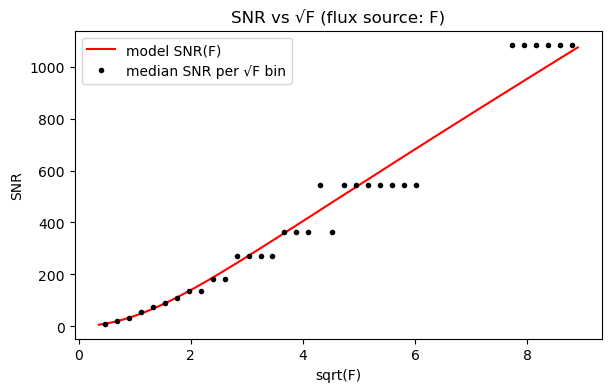

In [31]:
# Diagnostic: SNR vs sqrt(F) with model overlay (aligned flux proxy)
import numpy as np
import matplotlib.pyplot as plt

# Helper to fetch a numeric 1D flux proxy consistently with calibration
_def_sources = ['F_arr', 'F', 'F_all', 'flux']

def _to_1d_numeric(val):
    if isinstance(val, np.ndarray):
        arr = val
    elif isinstance(val, (list, tuple)) and len(val) > 0:
        try:
            parts = [np.asarray(x).ravel() for x in val]
            arr = np.concatenate(parts)
        except Exception:
            arr = np.asarray(val)
    else:
        arr = np.asarray(val)
    arr = arr.ravel()
    # filter non-finite and non-positive for sqrt
    with np.errstate(invalid='ignore'): 
        return arr[np.isfinite(arr) & (arr > 0)]

def get_flux_proxy():
    for name in _def_sources:
        if name in globals():
            try:
                arr = _to_1d_numeric(globals()[name])
                if arr.size > 0:
                    return arr, name
            except Exception:
                continue
    return None, None

F_proxy, src = get_flux_proxy()
if F_proxy is None or F_proxy.size == 0:
    print("Cannot plot SNR vs √F: no positive finite flux array found among F_arr, F, F_all, flux.")
else:
    x = np.sqrt(F_proxy)

    # Data SNR if available
    snr_data = None
    if 'snr' in globals():
        s = np.asarray(snr).ravel()
        if s.size == x.size:
            snr_data = s
    if snr_data is None and 'sigmaF_all' in globals():
        sF = np.asarray(sigmaF_all).ravel()
        if sF.size == F_proxy.size:
            with np.errstate(divide='ignore', invalid='ignore'):
                snr_data = F_proxy / sF

    # Model availability
    has_model = all([name in globals() for name in ['a','b','c']])
    if has_model:
        try:
            a_val, b_val, c_val = float(a), float(b), float(c)
        except Exception:
            has_model = False

    nbins = 40
    x_edges = np.linspace(np.nanpercentile(x, 1), np.nanpercentile(x, 99), nbins + 1)
    x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
    idx = np.digitize(x, x_edges) - 1
    valid = (idx >= 0) & (idx < nbins) & np.isfinite(x)

    med_snr = np.full(nbins, np.nan)
    if snr_data is not None:
        s = np.asarray(snr_data)
        valid = valid & np.isfinite(s)
        for i in range(nbins):
            sel = valid & (idx == i)
            if np.any(sel):
                med_snr[i] = np.nanmedian(s[sel])

    plt.figure(figsize=(6.8,4))
    if has_model:
        x_dense = np.linspace(np.nanmin(x[valid]), np.nanmax(x[valid]), 500)
        F_dense = x_dense**2
        snr_model = F_dense / np.sqrt(a*F_dense + b + c*F_dense**2)
        plt.plot(x_dense, snr_model, 'r-', lw=1.5, label='model SNR(F)')

    if np.any(np.isfinite(med_snr)):
        plt.plot(x_centers, med_snr, 'ko', ms=3, label='median SNR per √F bin')
    else:
        plt.plot([], [], 'ko', label='no aligned SNR data')

    plt.xlabel('sqrt(F)')
    plt.ylabel('SNR')
    plt.title(f'SNR vs √F (flux source: {src})')
    plt.legend()

    # Range diagnostics
    x_valid = x[valid]
    print(f"SNR plot √F range: [{np.nanmin(x_valid):.2f}, {np.nanmax(x_valid):.2f}] with nbins={nbins}; model={has_model}")
    plt.show()


# Empirical binning for uncertainty calibration and Gaussianity checks

You were binning with a purpose: to ensure posterior uncertainties reflect the empirical width of the model and to verify that residuals are Gaussian within flux bins. The next cells:

- Compute the per-bin scatter of normalized residuals `z` vs. flux proxy (we use `√F` by default for visual uniformity).
- Derive an empirical scale factor `s(F)` so that reported per-epoch uncertainties can be rescaled to match the observed width within each bin.
- Assess Gaussianity per bin via histograms with an N(0,1) overlay and QQ-plots, with normality test p-values.

This complements the parametric variance model: use it as a sanity check, and if needed, as a lightweight empirical correction in your likelihood/posterior.

In [32]:
# Empirical bin-based noise calibration and Gaussianity diagnostics
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.interpolate import interp1d

# Requirements: arrays `z` (normalized residuals per epoch) and a matching per-epoch flux array
try:
    z_arr = np.asarray(z).ravel()
except NameError as e:
    raise RuntimeError("Missing inputs: run the residuals cell that computes `z` first.") from e

# Attempt to find a per-epoch flux array aligned to z
flux_sources = ['flux', 'F', 'F_all', 'all_flux', 'F_model', 'Fplot']
mask_sources = ['keep', 'good', 'mask', 'nan_mask', 'sel']
F_arr = None
flux_name = None
mask_used = None

# Helper to try converting to 1D numeric array, concatenating lists-of-arrays when possible
def to_1d_array(val):
    # Already a numpy array
    if isinstance(val, np.ndarray):
        return val.ravel()
    # List/tuple: attempt to concatenate
    if isinstance(val, (list, tuple)) and len(val) > 0:
        try:
            parts = [np.asarray(x).ravel() for x in val]
            return np.concatenate(parts)
        except Exception:
            # Fall back to object array -> fail
            raise
    # Anything else
    arr = np.asarray(val)
    if arr.dtype == object:
        raise ValueError("object array")
    return arr.ravel()

# 1) Prefer exact length match
for name in flux_sources:
    val = globals().get(name, None)
    if val is None:
        continue
    try:
        arr = to_1d_array(val)
    except Exception:
        continue
    if arr.size == z_arr.size:
        F_arr = arr
        flux_name = name
        break

# 2) If not, try applying a boolean mask whose number of True equals len(z)
if F_arr is None:
    for fname in flux_sources:
        fval = globals().get(fname, None)
        if fval is None:
            continue
        try:
            farr = to_1d_array(fval)
        except Exception:
            continue
        for mname in mask_sources:
            mval = globals().get(mname, None)
            if mval is None:
                continue
            try:
                marr = np.asarray(mval).astype(bool).ravel()
            except Exception:
                continue
            if marr.size == farr.size and int(marr.sum()) == z_arr.size:
                F_arr = farr[marr]
                flux_name = f"{fname}[{mname}]"
                mask_used = mname
                break
        if F_arr is not None:
            break

# 3) Last resort: if nothing matches, abort with guidance
if F_arr is None:
    sizes = {}
    for name in flux_sources:
        val = globals().get(name, None)
        if val is None:
            continue
        try:
            sizes[name] = to_1d_array(val).size
        except Exception:
            sizes[name] = 'unavailable'
    raise RuntimeError(
        "Could not align a flux array to `z`. Available sizes: " + str(sizes) +
        ". If you used a mask to compute z, ensure that mask variable is available (e.g., `keep`, `good`) and re-run."
    )

# Choose binning in sqrt(F) for visually even sampling
x_proxy = np.sqrt(F_arr)
nbins = 30
edges = np.linspace(np.nanpercentile(x_proxy, 1), np.nanpercentile(x_proxy, 99), nbins + 1)
centers = 0.5 * (edges[:-1] + edges[1:])

bin_idx = np.digitize(x_proxy, edges) - 1
valid = (bin_idx >= 0) & (bin_idx < nbins) & np.isfinite(z_arr) & np.isfinite(x_proxy)
bin_idx = bin_idx[valid]
z_valid = z_arr[valid]
x_valid = x_proxy[valid]

# Compute per-bin robust scatter of z (use MAD*1.4826) and classical std
robust_std = np.full(nbins, np.nan)
std = np.full(nbins, np.nan)
count = np.zeros(nbins, dtype=int)
for b in range(nbins):
    sel = bin_idx == b
    if not np.any(sel):
        continue
    zz = z_valid[sel]
    count[b] = zz.size
    if zz.size >= 5:
        med = np.nanmedian(zz)
        mad = np.nanmedian(np.abs(zz - med))
        robust_std[b] = 1.4826 * mad
        std[b] = np.nanstd(zz, ddof=1)
    else:
        robust_std[b] = np.nan
        std[b] = np.nan

# Build an empirical scale factor s(F): target width is 1; current width ~ robust_std
good_bins = np.isfinite(robust_std) & (count >= 10)
if np.sum(good_bins) < 3:
    print("Warning: too few populated bins for a stable interpolant; falling back to constant scale = 1.0")
    s_of_x = lambda x: np.ones_like(np.asarray(x))
else:
    scale_vals = 1.0 / robust_std[good_bins]
    # Clip extreme scales to avoid pathological corrections
    scale_vals = np.clip(scale_vals, 0.3, 3.0)
    s_of_x = interp1d(centers[good_bins], scale_vals, kind='linear', fill_value=(scale_vals[0], scale_vals[-1]), bounds_error=False)

# Plot per-bin scatter and the implied scale factor
fig, ax = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
ax[0].errorbar(centers, robust_std, yerr=None, fmt='o', ms=4, color='tab:blue', label='robust std(z)')
ax[0].plot(centers, std, 'x', color='tab:orange', label='std(z)')
ax[0].axhline(1.0, color='k', lw=1, ls='--', label='target = 1')
ax[0].set_xlabel('sqrt(F)')
ax[0].set_ylabel('scatter of z per bin')
ax[0].legend()

finite_centers = centers[np.isfinite(robust_std)]
if finite_centers.size > 0:
    x_dense = np.linspace(finite_centers.min(), finite_centers.max(), 200)
else:
    x_dense = centers
ax[1].plot(x_dense, s_of_x(x_dense), color='tab:green')
subtitle = f'flux: {flux_name}' + (f', mask: {mask_used}' if mask_used else '')
ax[1].set_xlabel('sqrt(F)')
ax[1].set_ylabel('scale s(F) to apply to σ')
ax[1].set_title(f'Empirical error rescaling ({subtitle})')
plt.show()

# Example: applying the scale to per-epoch uncertainties for likelihood
# Given per-epoch magnitude errors sigma_m (or flux errors sigma_F), you can rescale as:
# sigma_m_rescaled = sigma_m / s_of_x(np.sqrt(F_arr))
pass

RuntimeError: Could not align a flux array to `z`. Available sizes: {'flux': 36, 'F': 148387, 'F_all': 148387, 'all_flux': 148387, 'F_model': 300, 'Fplot': 300}. If you used a mask to compute z, ensure that mask variable is available (e.g., `keep`, `good`) and re-run.

In [33]:
# Per-bin Gaussianity checks: histograms and QQ-plots (aligned to F_arr and with fitted Gaussian overlay)
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Choose residual source ('z' baseline-only or 'z_model' if you computed it)
residuals_name = 'z'
if residuals_name not in globals():
    raise RuntimeError(f"Residuals array '{residuals_name}' not found. Define it before running this cell.")

z_for_checks = np.asarray(globals()[residuals_name]).ravel()

# Use the same flux proxy as the SNR cell
try:
    F_proxy = F_arr
except NameError:
    F_proxy = np.asarray(F).ravel()

x_proxy = np.sqrt(F_proxy)
finite = np.isfinite(z_for_checks) & np.isfinite(x_proxy)
zv, xv = z_for_checks[finite], x_proxy[finite]

# Quantile binning for robustness
nbins = 12
edges = np.quantile(xv, np.linspace(0.0, 1.0, nbins + 1))
centers = 0.5 * (edges[:-1] + edges[1:])
bin_idx = np.clip(np.digitize(xv, edges) - 1, 0, nbins - 1)
counts = np.bincount(bin_idx, minlength=nbins)

min_n = max(30, int(0.002 * zv.size))
sample_bins = np.where(counts >= min_n)[0]
if sample_bins.size == 0:
    sample_bins = np.argsort(counts)[-6:]

nrows = min(sample_bins.size, 6)
fig, axes = plt.subplots(nrows, 2, figsize=(10, 2.8*nrows), constrained_layout=True)
if nrows == 1:
    axes = np.array([axes])

for i, b in enumerate(sample_bins[:nrows]):
    sel = bin_idx == b
    zz = zv[sel]
    ax_h, ax_q = axes[i, 0], axes[i, 1]
    if zz.size < 10:
        ax_h.text(0.5, 0.5, f'Bin {b}: n={zz.size} (<10)', ha='center', va='center')
        ax_h.axis('off'); ax_q.axis('off')
        continue

    # Histogram
    ax_h.hist(zz, bins=30, density=True, alpha=0.6, color='tab:blue')
    xg = np.linspace(np.nanpercentile(zz, 0.5) - 5, np.nanpercentile(zz, 99.5) + 5, 400)
    # Overlay N(0,1) and fitted N(mu, sigma)
    mu, sd = np.mean(zz), np.std(zz, ddof=1)
    ax_h.plot(xg, stats.norm.pdf(xg, 0, 1), 'k--', lw=1, label='N(0,1)')
    ax_h.plot(xg, stats.norm.pdf(xg, mu, sd), 'r-', lw=1, label='fit N(μ,σ)')
    ax_h.set_title(f'Bin {b} (√F≈{centers[b]:.2f}), n={zz.size}, μ={mu:.2f}, σ={sd:.2f}')
    ax_h.set_xlabel('z'); ax_h.set_ylabel('density')
    ax_h.legend(loc='upper right', fontsize=8)

    # QQ-plot vs fitted normal (centered and scaled)
    if sd > 0:
        z_std = (zz - mu) / sd
    else:
        z_std = zz * 0.0
    (theo, ordered), (slope, intercept, r) = stats.probplot(z_std, dist='norm')
    ax_q.plot(theo, ordered, 'o', ms=3)
    ax_q.plot(theo, theo, 'r-', lw=1, label='N(0,1) line')
    ax_q.set_title(f'QQ (standardized), r={r:.3f}')
    ax_q.set_xlabel('N(0,1) quantiles'); ax_q.set_ylabel('sample quantiles')

    # Normality tests summary (on standardized residuals)
    try:
        sw_stat, sw_p = stats.shapiro(z_std[:5000])
        jb_stat, jb_p = stats.jarque_bera(z_std)
        ax_h.text(0.02, 0.95, f'Shapiro p={sw_p:.2g}\nJB p={jb_p:.2g}', transform=ax_h.transAxes, va='top', ha='left', fontsize=9)
    except Exception as e:
        ax_h.text(0.02, 0.95, f'Test err: {e}', transform=ax_h.transAxes, va='top', ha='left', fontsize=8)

plt.show()

# Print range diagnostics to compare with SNR plot
print(f"QQ/hist √F range: [{xv.min():.2f}, {xv.max():.2f}], nbins={nbins}, min_n={min_n}, bins_used={list(sample_bins[:nrows])}")
pass

TypeError: loop of ufunc does not support argument 0 of type NoneType which has no callable sqrt method

## Using the empirical scale in inference

- Purpose: Your binning estimates the width of residuals as a function of flux. Convert that into a multiplicative scale `s(F)` so the likelihood uses `σ_rescaled = σ_reported / s(√F)` to make z-scatter ≈ 1 across the flux range.
- When to use:
  - Prefer the parametric variance model `σ_F^2 = aF + b + cF^2` if it fits well and residuals look Gaussian (cleaner extrapolation, physical).
  - Use the empirical `s(F)` as a correction layer when residuals show mild flux-dependent miscalibration, or for quick downstream analyses.
- Practical:
  - For magnitude errors `σ_m`, compute `σ_m_rescaled = σ_m / s(√F)`. For flux errors `σ_F`, same pattern with `√F` from flux.
  - In MCMC/ODR, multiply per-epoch weights by `s(√F)^2` (equivalently divide variances by `s(√F)^2`).
  - Keep `s(F)` clipped within [0.3, 3.0] to avoid over-corrections from noisy bins.
- Validation: Re-run the z-scatter and Gaussianity checks after rescaling; the per-bin robust std should hug 1, normality p-values should not systematically plummet at bright/faint ends.

## What is `z`, and what about magnified epochs?

- `z` means normalized residuals: observation minus model, divided by the reported 1σ for that epoch.
  - In flux: `z = (F − F_model) / σ_F`.
  - In magnitudes: `z = (m − m_model) / σ_m`, with `σ_m ≈ (2.5/ln 10) · σ_F/F`.
- Baseline-only vs magnified epochs:
  - To validate error calibration independent of the microlensing signal, we often use only baseline epochs per event (i.e., outside the bump) with a flat model. That avoids conflating model mismatch with noise calibration.
  - Magnified epochs are still valid for the SNR model—they probe higher flux where noise is smaller. To include them, compute residuals relative to a light-curve model `F_model(t)` and then form `z` using that model, not a flat baseline.

Below, you can switch between baseline residuals (`z`) and model-subtracted residuals (`z_model`) for the Gaussianity/QQ diagnostics and for the bin-based calibration.